In [1]:
import os
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from matplotlib import pylab as plt

import optuna

In [2]:
token = os.environ['oanda_access_token']
account = os.environ['oanda_account_id']

In [3]:
from my_oanda.my_oanda import Bot

In [4]:
class MyBot(Bot):
    def set_param(self, a, b, c, d, stop_loss, take_profit):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        self.params = {"a":a, "b":b, "c":c, "d":d, "stop_loss":stop_loss, "take_profit":take_profit}
        
    def atr(self, *, period: int = 14, price: str = "C"):
        a = (self.df.H - self.df.L).abs()
        b = (self.df.H - self.df[price].shift()).abs()
        c = (self.df.L - self.df[price].shift()).abs()

        df = pd.concat([a, b, c], axis=1).max(axis=1)
        return df.ewm(span=period).mean()
        
    def strategy(self):
        rsi = self.rsi(period=self.a)
        ema = self.ema(period=self.b)
        atr = self.atr(period=self.c)
        lower = ema - atr
        upper = ema + atr
        self.buy_entry = (rsi < self.d )& (self.df.C < lower)
        self.sell_entry = (rsi > 100-self.d) & (self.df.C > upper)
        self.sell_exit = ema > self.df.C
        self.buy_exit = ema < self.df.C


In [5]:
start = "2020-1-1"
end = "2020-12-31"
glan = "M5"
inst = "USD_JPY"

In [6]:
mybot = MyBot(
    account_id=account,
    access_token=token,
    environment='live',
    instrument=inst,
    granularity=glan, # 15 second candlestick,
    folder = "../data/"
)

In [7]:
df_list = []

def objective(trial):
    a = trial.suggest_int('a', 5, 50)
    b = trial.suggest_int('b', 5, 50)
    c = trial.suggest_int('c', 5, 50)
    d = trial.suggest_int('d', 20, 40)
    
    sl = trial.suggest_int('stop_loss', 5, 50)
    tp = trial.suggest_int('take_profit', 5, 50)
    
    mybot.set_param(a, b, c, d, sl, tp)
    
    df =  mybot.backtest(from_date=start, to_date=end)
    df.loc['a'] = a
    df.loc['b'] = b
    df.loc['c'] = c
    df.loc['d'] = d
    df.loc['stop_loss'] = sl
    df.loc['take_profit'] = tp
    
    df_list.append(df)
    
    score = -df['total profit']
    #     print('a: %d, b: %d, score: %1.2f' % (a, b, -score))
    return score

In [8]:
df_list = []
study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2021-02-21 18:50:08,895] A new study created in memory with name: no-name-78f88aaf-8b3f-4540-b45b-6d7b90e19ba1
[I 2021-02-21 18:50:49,597] Trial 0 finished with value: -5240.0 and parameters: {'a': 42, 'b': 27, 'c': 13, 'd': 30, 'stop_loss': 10, 'take_profit': 36}. Best is trial 0 with value: -5240.0.
[I 2021-02-21 18:50:50,246] Trial 1 finished with value: -33490.0 and parameters: {'a': 36, 'b': 37, 'c': 32, 'd': 34, 'stop_loss': 43, 'take_profit': 9}. Best is trial 1 with value: -33490.0.
[I 2021-02-21 18:50:50,786] Trial 2 finished with value: 9500.0 and parameters: {'a': 38, 'b': 13, 'c': 30, 'd': 30, 'stop_loss': 50, 'take_profit': 48}. Best is trial 1 with value: -33490.0.
[I 2021-02-21 18:50:51,407] Trial 3 finished with value: -51560.0 and parameters: {'a': 11, 'b': 28, 'c': 17, 'd': 21, 'stop_loss': 29, 'take_profit': 34}. Best is trial 3 with value: -51560.0.
[I 2021-02-21 18:50:52,126] Trial 4 finished with value: -13850.0 and parameters: {'a': 13, 'b': 25, 'c': 23, 'd': 

[I 2021-02-21 18:51:14,577] Trial 39 finished with value: -104260.0 and parameters: {'a': 5, 'b': 40, 'c': 33, 'd': 32, 'stop_loss': 13, 'take_profit': 34}. Best is trial 24 with value: -225330.0.
[I 2021-02-21 18:51:15,251] Trial 40 finished with value: -73740.0 and parameters: {'a': 13, 'b': 45, 'c': 50, 'd': 29, 'stop_loss': 43, 'take_profit': 33}. Best is trial 24 with value: -225330.0.
[I 2021-02-21 18:51:15,923] Trial 41 finished with value: -183730.0 and parameters: {'a': 19, 'b': 48, 'c': 47, 'd': 33, 'stop_loss': 5, 'take_profit': 39}. Best is trial 24 with value: -225330.0.
[I 2021-02-21 18:51:16,519] Trial 42 finished with value: -150710.0 and parameters: {'a': 18, 'b': 46, 'c': 48, 'd': 33, 'stop_loss': 9, 'take_profit': 36}. Best is trial 24 with value: -225330.0.
[I 2021-02-21 18:51:17,138] Trial 43 finished with value: -175400.0 and parameters: {'a': 20, 'b': 42, 'c': 42, 'd': 31, 'stop_loss': 7, 'take_profit': 44}. Best is trial 24 with value: -225330.0.
[I 2021-02-21 1

[I 2021-02-21 18:51:41,870] Trial 79 finished with value: -175040.0 and parameters: {'a': 5, 'b': 46, 'c': 46, 'd': 31, 'stop_loss': 6, 'take_profit': 48}. Best is trial 24 with value: -225330.0.
[I 2021-02-21 18:51:42,514] Trial 80 finished with value: -176030.0 and parameters: {'a': 8, 'b': 43, 'c': 43, 'd': 30, 'stop_loss': 9, 'take_profit': 45}. Best is trial 24 with value: -225330.0.
[I 2021-02-21 18:51:43,242] Trial 81 finished with value: -178170.0 and parameters: {'a': 6, 'b': 49, 'c': 44, 'd': 32, 'stop_loss': 7, 'take_profit': 41}. Best is trial 24 with value: -225330.0.
[I 2021-02-21 18:51:44,009] Trial 82 finished with value: -205820.0 and parameters: {'a': 9, 'b': 44, 'c': 48, 'd': 31, 'stop_loss': 5, 'take_profit': 43}. Best is trial 24 with value: -225330.0.
[I 2021-02-21 18:51:44,716] Trial 83 finished with value: -208810.0 and parameters: {'a': 11, 'b': 44, 'c': 48, 'd': 31, 'stop_loss': 5, 'take_profit': 43}. Best is trial 24 with value: -225330.0.
[I 2021-02-21 18:51

[I 2021-02-21 18:52:08,625] Trial 118 finished with value: -142350.0 and parameters: {'a': 19, 'b': 44, 'c': 49, 'd': 30, 'stop_loss': 8, 'take_profit': 41}. Best is trial 110 with value: -234060.0.
[I 2021-02-21 18:52:09,213] Trial 119 finished with value: -110090.0 and parameters: {'a': 16, 'b': 5, 'c': 44, 'd': 31, 'stop_loss': 10, 'take_profit': 44}. Best is trial 110 with value: -234060.0.
[I 2021-02-21 18:52:10,034] Trial 120 finished with value: -195100.0 and parameters: {'a': 8, 'b': 46, 'c': 47, 'd': 33, 'stop_loss': 5, 'take_profit': 50}. Best is trial 110 with value: -234060.0.
[I 2021-02-21 18:52:10,792] Trial 121 finished with value: -204690.0 and parameters: {'a': 10, 'b': 38, 'c': 48, 'd': 30, 'stop_loss': 5, 'take_profit': 47}. Best is trial 110 with value: -234060.0.
[I 2021-02-21 18:52:11,490] Trial 122 finished with value: -193590.0 and parameters: {'a': 12, 'b': 41, 'c': 50, 'd': 32, 'stop_loss': 6, 'take_profit': 46}. Best is trial 110 with value: -234060.0.
[I 202

[I 2021-02-21 18:52:35,829] Trial 157 finished with value: -55660.0 and parameters: {'a': 48, 'b': 47, 'c': 30, 'd': 32, 'stop_loss': 8, 'take_profit': 50}. Best is trial 110 with value: -234060.0.
[I 2021-02-21 18:52:36,521] Trial 158 finished with value: -206300.0 and parameters: {'a': 13, 'b': 48, 'c': 28, 'd': 33, 'stop_loss': 10, 'take_profit': 46}. Best is trial 110 with value: -234060.0.
[I 2021-02-21 18:52:37,217] Trial 159 finished with value: -185860.0 and parameters: {'a': 14, 'b': 50, 'c': 31, 'd': 34, 'stop_loss': 7, 'take_profit': 48}. Best is trial 110 with value: -234060.0.
[I 2021-02-21 18:52:37,933] Trial 160 finished with value: -206480.0 and parameters: {'a': 12, 'b': 46, 'c': 36, 'd': 35, 'stop_loss': 9, 'take_profit': 49}. Best is trial 110 with value: -234060.0.
[I 2021-02-21 18:52:38,675] Trial 161 finished with value: -183810.0 and parameters: {'a': 10, 'b': 49, 'c': 29, 'd': 32, 'stop_loss': 8, 'take_profit': 45}. Best is trial 110 with value: -234060.0.
[I 20

[I 2021-02-21 18:53:02,717] Trial 196 finished with value: -217630.0 and parameters: {'a': 12, 'b': 46, 'c': 28, 'd': 36, 'stop_loss': 6, 'take_profit': 47}. Best is trial 110 with value: -234060.0.
[I 2021-02-21 18:53:03,503] Trial 197 finished with value: -214190.0 and parameters: {'a': 11, 'b': 46, 'c': 25, 'd': 34, 'stop_loss': 6, 'take_profit': 47}. Best is trial 110 with value: -234060.0.
[I 2021-02-21 18:53:04,214] Trial 198 finished with value: -207990.0 and parameters: {'a': 13, 'b': 45, 'c': 23, 'd': 35, 'stop_loss': 6, 'take_profit': 47}. Best is trial 110 with value: -234060.0.
[I 2021-02-21 18:53:04,871] Trial 199 finished with value: -201820.0 and parameters: {'a': 11, 'b': 45, 'c': 20, 'd': 34, 'stop_loss': 7, 'take_profit': 48}. Best is trial 110 with value: -234060.0.
[I 2021-02-21 18:53:05,586] Trial 200 finished with value: -215540.0 and parameters: {'a': 12, 'b': 46, 'c': 27, 'd': 36, 'stop_loss': 6, 'take_profit': 46}. Best is trial 110 with value: -234060.0.
[I 20

[I 2021-02-21 18:53:31,453] Trial 235 finished with value: -228760.0 and parameters: {'a': 15, 'b': 47, 'c': 24, 'd': 39, 'stop_loss': 5, 'take_profit': 41}. Best is trial 214 with value: -248050.0.
[I 2021-02-21 18:53:32,196] Trial 236 finished with value: -230680.0 and parameters: {'a': 14, 'b': 47, 'c': 24, 'd': 39, 'stop_loss': 5, 'take_profit': 40}. Best is trial 214 with value: -248050.0.
[I 2021-02-21 18:53:32,878] Trial 237 finished with value: -224000.0 and parameters: {'a': 15, 'b': 47, 'c': 24, 'd': 39, 'stop_loss': 5, 'take_profit': 40}. Best is trial 214 with value: -248050.0.
[I 2021-02-21 18:53:33,619] Trial 238 finished with value: -228520.0 and parameters: {'a': 14, 'b': 45, 'c': 25, 'd': 39, 'stop_loss': 5, 'take_profit': 39}. Best is trial 214 with value: -248050.0.
[I 2021-02-21 18:53:34,395] Trial 239 finished with value: -230050.0 and parameters: {'a': 15, 'b': 48, 'c': 26, 'd': 40, 'stop_loss': 5, 'take_profit': 41}. Best is trial 214 with value: -248050.0.
[I 20

[I 2021-02-21 18:54:01,804] Trial 274 finished with value: -239120.0 and parameters: {'a': 19, 'b': 48, 'c': 22, 'd': 40, 'stop_loss': 5, 'take_profit': 43}. Best is trial 259 with value: -249020.0.
[I 2021-02-21 18:54:02,466] Trial 275 finished with value: -73420.0 and parameters: {'a': 20, 'b': 49, 'c': 22, 'd': 40, 'stop_loss': 32, 'take_profit': 44}. Best is trial 259 with value: -249020.0.
[I 2021-02-21 18:54:03,166] Trial 276 finished with value: -220670.0 and parameters: {'a': 19, 'b': 48, 'c': 21, 'd': 36, 'stop_loss': 6, 'take_profit': 43}. Best is trial 259 with value: -249020.0.
[I 2021-02-21 18:54:03,896] Trial 277 finished with value: -205990.0 and parameters: {'a': 22, 'b': 49, 'c': 19, 'd': 40, 'stop_loss': 5, 'take_profit': 43}. Best is trial 259 with value: -249020.0.
[I 2021-02-21 18:54:04,623] Trial 278 finished with value: -192640.0 and parameters: {'a': 19, 'b': 50, 'c': 20, 'd': 40, 'stop_loss': 6, 'take_profit': 42}. Best is trial 259 with value: -249020.0.
[I 20

[I 2021-02-21 18:54:30,574] Trial 313 finished with value: -107950.0 and parameters: {'a': 20, 'b': 49, 'c': 15, 'd': 36, 'stop_loss': 19, 'take_profit': 42}. Best is trial 307 with value: -250400.0.
[I 2021-02-21 18:54:31,313] Trial 314 finished with value: -212520.0 and parameters: {'a': 19, 'b': 50, 'c': 17, 'd': 37, 'stop_loss': 6, 'take_profit': 45}. Best is trial 307 with value: -250400.0.
[I 2021-02-21 18:54:31,985] Trial 315 finished with value: -156050.0 and parameters: {'a': 18, 'b': 49, 'c': 19, 'd': 35, 'stop_loss': 7, 'take_profit': 14}. Best is trial 307 with value: -250400.0.
[I 2021-02-21 18:54:32,683] Trial 316 finished with value: -228090.0 and parameters: {'a': 20, 'b': 50, 'c': 16, 'd': 37, 'stop_loss': 5, 'take_profit': 44}. Best is trial 307 with value: -250400.0.
[I 2021-02-21 18:54:33,412] Trial 317 finished with value: -246040.0 and parameters: {'a': 19, 'b': 49, 'c': 14, 'd': 36, 'stop_loss': 5, 'take_profit': 42}. Best is trial 307 with value: -250400.0.
[I 2

[I 2021-02-21 18:54:57,718] Trial 352 finished with value: -228030.0 and parameters: {'a': 18, 'b': 49, 'c': 15, 'd': 35, 'stop_loss': 5, 'take_profit': 43}. Best is trial 307 with value: -250400.0.
[I 2021-02-21 18:54:58,428] Trial 353 finished with value: -179060.0 and parameters: {'a': 21, 'b': 45, 'c': 19, 'd': 39, 'stop_loss': 6, 'take_profit': 45}. Best is trial 307 with value: -250400.0.
[I 2021-02-21 18:54:59,236] Trial 354 finished with value: -239300.0 and parameters: {'a': 17, 'b': 48, 'c': 20, 'd': 40, 'stop_loss': 5, 'take_profit': 42}. Best is trial 307 with value: -250400.0.
[I 2021-02-21 18:55:00,020] Trial 355 finished with value: -198430.0 and parameters: {'a': 17, 'b': 46, 'c': 20, 'd': 36, 'stop_loss': 7, 'take_profit': 41}. Best is trial 307 with value: -250400.0.
[I 2021-02-21 18:55:00,783] Trial 356 finished with value: -177400.0 and parameters: {'a': 17, 'b': 48, 'c': 21, 'd': 37, 'stop_loss': 6, 'take_profit': 40}. Best is trial 307 with value: -250400.0.
[I 20

[I 2021-02-21 18:55:30,977] Trial 391 finished with value: -216740.0 and parameters: {'a': 17, 'b': 46, 'c': 23, 'd': 36, 'stop_loss': 5, 'take_profit': 42}. Best is trial 307 with value: -250400.0.
[I 2021-02-21 18:55:32,110] Trial 392 finished with value: -209750.0 and parameters: {'a': 18, 'b': 49, 'c': 21, 'd': 35, 'stop_loss': 8, 'take_profit': 43}. Best is trial 307 with value: -250400.0.
[I 2021-02-21 18:55:33,500] Trial 393 finished with value: -179830.0 and parameters: {'a': 19, 'b': 47, 'c': 22, 'd': 39, 'stop_loss': 7, 'take_profit': 41}. Best is trial 307 with value: -250400.0.
[I 2021-02-21 18:55:34,422] Trial 394 finished with value: -222970.0 and parameters: {'a': 21, 'b': 50, 'c': 18, 'd': 40, 'stop_loss': 5, 'take_profit': 45}. Best is trial 307 with value: -250400.0.
[I 2021-02-21 18:55:35,269] Trial 395 finished with value: -183210.0 and parameters: {'a': 18, 'b': 48, 'c': 20, 'd': 37, 'stop_loss': 6, 'take_profit': 42}. Best is trial 307 with value: -250400.0.
[I 20

[I 2021-02-21 18:56:05,499] Trial 430 finished with value: -178170.0 and parameters: {'a': 17, 'b': 48, 'c': 19, 'd': 37, 'stop_loss': 6, 'take_profit': 42}. Best is trial 398 with value: -250440.0.
[I 2021-02-21 18:56:06,645] Trial 431 finished with value: -239110.0 and parameters: {'a': 19, 'b': 48, 'c': 23, 'd': 40, 'stop_loss': 5, 'take_profit': 43}. Best is trial 398 with value: -250440.0.
[I 2021-02-21 18:56:07,539] Trial 432 finished with value: -227690.0 and parameters: {'a': 16, 'b': 50, 'c': 25, 'd': 36, 'stop_loss': 5, 'take_profit': 44}. Best is trial 398 with value: -250440.0.
[I 2021-02-21 18:56:08,850] Trial 433 finished with value: -202120.0 and parameters: {'a': 18, 'b': 47, 'c': 20, 'd': 38, 'stop_loss': 6, 'take_profit': 42}. Best is trial 398 with value: -250440.0.
[I 2021-02-21 18:56:09,915] Trial 434 finished with value: -171380.0 and parameters: {'a': 21, 'b': 49, 'c': 15, 'd': 35, 'stop_loss': 7, 'take_profit': 44}. Best is trial 398 with value: -250440.0.
[I 20

[I 2021-02-21 18:56:54,926] Trial 469 finished with value: -252710.0 and parameters: {'a': 16, 'b': 49, 'c': 19, 'd': 39, 'stop_loss': 5, 'take_profit': 43}. Best is trial 469 with value: -252710.0.
[I 2021-02-21 18:56:55,749] Trial 470 finished with value: -80690.0 and parameters: {'a': 16, 'b': 49, 'c': 19, 'd': 39, 'stop_loss': 46, 'take_profit': 44}. Best is trial 469 with value: -252710.0.
[I 2021-02-21 18:56:56,699] Trial 471 finished with value: -242540.0 and parameters: {'a': 15, 'b': 49, 'c': 17, 'd': 38, 'stop_loss': 5, 'take_profit': 43}. Best is trial 469 with value: -252710.0.
[I 2021-02-21 18:56:57,664] Trial 472 finished with value: -196180.0 and parameters: {'a': 15, 'b': 50, 'c': 16, 'd': 38, 'stop_loss': 7, 'take_profit': 45}. Best is trial 469 with value: -252710.0.
[I 2021-02-21 18:56:58,592] Trial 473 finished with value: -230660.0 and parameters: {'a': 15, 'b': 43, 'c': 17, 'd': 38, 'stop_loss': 5, 'take_profit': 43}. Best is trial 469 with value: -252710.0.
[I 20

[I 2021-02-21 18:57:30,346] Trial 508 finished with value: -240920.0 and parameters: {'a': 12, 'b': 50, 'c': 13, 'd': 37, 'stop_loss': 5, 'take_profit': 46}. Best is trial 469 with value: -252710.0.
[I 2021-02-21 18:57:31,207] Trial 509 finished with value: -212230.0 and parameters: {'a': 13, 'b': 49, 'c': 15, 'd': 38, 'stop_loss': 6, 'take_profit': 43}. Best is trial 469 with value: -252710.0.
[I 2021-02-21 18:57:32,046] Trial 510 finished with value: -240120.0 and parameters: {'a': 12, 'b': 48, 'c': 14, 'd': 37, 'stop_loss': 5, 'take_profit': 42}. Best is trial 469 with value: -252710.0.
[I 2021-02-21 18:57:32,861] Trial 511 finished with value: -252760.0 and parameters: {'a': 13, 'b': 50, 'c': 16, 'd': 37, 'stop_loss': 5, 'take_profit': 45}. Best is trial 511 with value: -252760.0.
[I 2021-02-21 18:57:33,669] Trial 512 finished with value: -216890.0 and parameters: {'a': 12, 'b': 50, 'c': 14, 'd': 37, 'stop_loss': 6, 'take_profit': 46}. Best is trial 511 with value: -252760.0.
[I 20

[I 2021-02-21 18:58:01,196] Trial 547 finished with value: -204010.0 and parameters: {'a': 13, 'b': 48, 'c': 18, 'd': 36, 'stop_loss': 7, 'take_profit': 49}. Best is trial 521 with value: -256500.0.
[I 2021-02-21 18:58:01,950] Trial 548 finished with value: -234320.0 and parameters: {'a': 15, 'b': 49, 'c': 17, 'd': 36, 'stop_loss': 5, 'take_profit': 46}. Best is trial 521 with value: -256500.0.
[I 2021-02-21 18:58:02,676] Trial 549 finished with value: -221660.0 and parameters: {'a': 14, 'b': 47, 'c': 15, 'd': 36, 'stop_loss': 6, 'take_profit': 45}. Best is trial 521 with value: -256500.0.
[I 2021-02-21 18:58:03,418] Trial 550 finished with value: -236600.0 and parameters: {'a': 13, 'b': 49, 'c': 16, 'd': 35, 'stop_loss': 5, 'take_profit': 45}. Best is trial 521 with value: -256500.0.
[I 2021-02-21 18:58:04,082] Trial 551 finished with value: -198460.0 and parameters: {'a': 15, 'b': 48, 'c': 18, 'd': 36, 'stop_loss': 7, 'take_profit': 46}. Best is trial 521 with value: -256500.0.
[I 20

[I 2021-02-21 18:58:29,949] Trial 586 finished with value: -227510.0 and parameters: {'a': 11, 'b': 45, 'c': 12, 'd': 35, 'stop_loss': 5, 'take_profit': 48}. Best is trial 552 with value: -258630.0.
[I 2021-02-21 18:58:30,713] Trial 587 finished with value: -206020.0 and parameters: {'a': 12, 'b': 46, 'c': 11, 'd': 36, 'stop_loss': 7, 'take_profit': 49}. Best is trial 552 with value: -258630.0.
[I 2021-02-21 18:58:31,431] Trial 588 finished with value: -208720.0 and parameters: {'a': 14, 'b': 44, 'c': 13, 'd': 37, 'stop_loss': 8, 'take_profit': 49}. Best is trial 552 with value: -258630.0.
[I 2021-02-21 18:58:32,100] Trial 589 finished with value: -199670.0 and parameters: {'a': 13, 'b': 46, 'c': 10, 'd': 35, 'stop_loss': 6, 'take_profit': 47}. Best is trial 552 with value: -258630.0.
[I 2021-02-21 18:58:32,831] Trial 590 finished with value: -238630.0 and parameters: {'a': 15, 'b': 46, 'c': 12, 'd': 36, 'stop_loss': 5, 'take_profit': 49}. Best is trial 552 with value: -258630.0.
[I 20

[I 2021-02-21 18:58:58,554] Trial 625 finished with value: -220190.0 and parameters: {'a': 11, 'b': 46, 'c': 13, 'd': 34, 'stop_loss': 6, 'take_profit': 48}. Best is trial 552 with value: -258630.0.
[I 2021-02-21 18:58:59,320] Trial 626 finished with value: -213480.0 and parameters: {'a': 11, 'b': 48, 'c': 14, 'd': 34, 'stop_loss': 7, 'take_profit': 49}. Best is trial 552 with value: -258630.0.
[I 2021-02-21 18:58:59,933] Trial 627 finished with value: -199790.0 and parameters: {'a': 12, 'b': 7, 'c': 12, 'd': 34, 'stop_loss': 5, 'take_profit': 46}. Best is trial 552 with value: -258630.0.
[I 2021-02-21 18:59:00,678] Trial 628 finished with value: -203550.0 and parameters: {'a': 10, 'b': 47, 'c': 15, 'd': 35, 'stop_loss': 6, 'take_profit': 47}. Best is trial 552 with value: -258630.0.
[I 2021-02-21 18:59:01,449] Trial 629 finished with value: -246900.0 and parameters: {'a': 12, 'b': 48, 'c': 13, 'd': 35, 'stop_loss': 5, 'take_profit': 48}. Best is trial 552 with value: -258630.0.
[I 202

[I 2021-02-21 18:59:27,378] Trial 664 finished with value: -96640.0 and parameters: {'a': 13, 'b': 44, 'c': 10, 'd': 37, 'stop_loss': 22, 'take_profit': 45}. Best is trial 552 with value: -258630.0.
[I 2021-02-21 18:59:28,158] Trial 665 finished with value: -208550.0 and parameters: {'a': 14, 'b': 48, 'c': 14, 'd': 35, 'stop_loss': 6, 'take_profit': 47}. Best is trial 552 with value: -258630.0.
[I 2021-02-21 18:59:28,883] Trial 666 finished with value: -204530.0 and parameters: {'a': 12, 'b': 46, 'c': 12, 'd': 36, 'stop_loss': 9, 'take_profit': 46}. Best is trial 552 with value: -258630.0.
[I 2021-02-21 18:59:29,625] Trial 667 finished with value: -210590.0 and parameters: {'a': 13, 'b': 16, 'c': 11, 'd': 37, 'stop_loss': 5, 'take_profit': 47}. Best is trial 552 with value: -258630.0.
[I 2021-02-21 18:59:30,340] Trial 668 finished with value: -189080.0 and parameters: {'a': 15, 'b': 47, 'c': 15, 'd': 35, 'stop_loss': 6, 'take_profit': 46}. Best is trial 552 with value: -258630.0.
[I 20

[I 2021-02-21 18:59:55,981] Trial 703 finished with value: -66190.0 and parameters: {'a': 28, 'b': 45, 'c': 15, 'd': 27, 'stop_loss': 40, 'take_profit': 21}. Best is trial 552 with value: -258630.0.
[I 2021-02-21 18:59:56,745] Trial 704 finished with value: -224340.0 and parameters: {'a': 12, 'b': 47, 'c': 16, 'd': 37, 'stop_loss': 6, 'take_profit': 48}. Best is trial 552 with value: -258630.0.
[I 2021-02-21 18:59:57,471] Trial 705 finished with value: -229140.0 and parameters: {'a': 16, 'b': 44, 'c': 14, 'd': 36, 'stop_loss': 5, 'take_profit': 49}. Best is trial 552 with value: -258630.0.
[I 2021-02-21 18:59:58,200] Trial 706 finished with value: -215740.0 and parameters: {'a': 14, 'b': 46, 'c': 13, 'd': 35, 'stop_loss': 8, 'take_profit': 50}. Best is trial 552 with value: -258630.0.
[I 2021-02-21 18:59:59,000] Trial 707 finished with value: -258670.0 and parameters: {'a': 13, 'b': 47, 'c': 15, 'd': 36, 'stop_loss': 5, 'take_profit': 47}. Best is trial 707 with value: -258670.0.
[I 20

[I 2021-02-21 19:00:25,453] Trial 742 finished with value: -199620.0 and parameters: {'a': 10, 'b': 45, 'c': 11, 'd': 37, 'stop_loss': 5, 'take_profit': 48}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:00:26,182] Trial 743 finished with value: -202110.0 and parameters: {'a': 13, 'b': 48, 'c': 14, 'd': 34, 'stop_loss': 9, 'take_profit': 47}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:00:26,963] Trial 744 finished with value: -234050.0 and parameters: {'a': 13, 'b': 46, 'c': 12, 'd': 35, 'stop_loss': 5, 'take_profit': 46}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:00:27,711] Trial 745 finished with value: -166690.0 and parameters: {'a': 12, 'b': 34, 'c': 14, 'd': 39, 'stop_loss': 7, 'take_profit': 48}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:00:28,448] Trial 746 finished with value: -195240.0 and parameters: {'a': 15, 'b': 48, 'c': 13, 'd': 36, 'stop_loss': 6, 'take_profit': 46}. Best is trial 707 with value: -258670.0.
[I 20

[I 2021-02-21 19:00:54,456] Trial 781 finished with value: -189390.0 and parameters: {'a': 12, 'b': 46, 'c': 7, 'd': 28, 'stop_loss': 6, 'take_profit': 47}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:00:55,245] Trial 782 finished with value: -233630.0 and parameters: {'a': 13, 'b': 44, 'c': 10, 'd': 35, 'stop_loss': 5, 'take_profit': 45}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:00:55,838] Trial 783 finished with value: -83610.0 and parameters: {'a': 49, 'b': 47, 'c': 9, 'd': 35, 'stop_loss': 24, 'take_profit': 46}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:00:56,623] Trial 784 finished with value: -182020.0 and parameters: {'a': 14, 'b': 46, 'c': 7, 'd': 34, 'stop_loss': 6, 'take_profit': 48}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:00:57,355] Trial 785 finished with value: -198440.0 and parameters: {'a': 13, 'b': 45, 'c': 10, 'd': 36, 'stop_loss': 7, 'take_profit': 47}. Best is trial 707 with value: -258670.0.
[I 2021-

[I 2021-02-21 19:01:23,068] Trial 820 finished with value: -237390.0 and parameters: {'a': 12, 'b': 45, 'c': 11, 'd': 36, 'stop_loss': 5, 'take_profit': 45}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:01:23,854] Trial 821 finished with value: -185200.0 and parameters: {'a': 5, 'b': 47, 'c': 10, 'd': 37, 'stop_loss': 6, 'take_profit': 47}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:01:24,628] Trial 822 finished with value: -230560.0 and parameters: {'a': 13, 'b': 45, 'c': 11, 'd': 35, 'stop_loss': 5, 'take_profit': 49}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:01:25,258] Trial 823 finished with value: -136450.0 and parameters: {'a': 40, 'b': 48, 'c': 9, 'd': 36, 'stop_loss': 7, 'take_profit': 49}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:01:26,007] Trial 824 finished with value: -174550.0 and parameters: {'a': 14, 'b': 46, 'c': 8, 'd': 37, 'stop_loss': 6, 'take_profit': 15}. Best is trial 707 with value: -258670.0.
[I 2021-

[I 2021-02-21 19:01:52,891] Trial 859 finished with value: -247410.0 and parameters: {'a': 12, 'b': 45, 'c': 10, 'd': 35, 'stop_loss': 5, 'take_profit': 47}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:01:53,616] Trial 860 finished with value: -200620.0 and parameters: {'a': 15, 'b': 46, 'c': 12, 'd': 36, 'stop_loss': 7, 'take_profit': 46}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:01:54,356] Trial 861 finished with value: -194440.0 and parameters: {'a': 14, 'b': 47, 'c': 9, 'd': 37, 'stop_loss': 9, 'take_profit': 48}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:01:55,160] Trial 862 finished with value: -252980.0 and parameters: {'a': 13, 'b': 48, 'c': 13, 'd': 36, 'stop_loss': 5, 'take_profit': 45}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:01:55,951] Trial 863 finished with value: -193460.0 and parameters: {'a': 16, 'b': 49, 'c': 11, 'd': 36, 'stop_loss': 6, 'take_profit': 45}. Best is trial 707 with value: -258670.0.
[I 202

[I 2021-02-21 19:02:22,261] Trial 898 finished with value: -208540.0 and parameters: {'a': 13, 'b': 48, 'c': 12, 'd': 37, 'stop_loss': 8, 'take_profit': 48}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:02:22,943] Trial 899 finished with value: -188330.0 and parameters: {'a': 16, 'b': 47, 'c': 10, 'd': 36, 'stop_loss': 6, 'take_profit': 44}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:02:23,683] Trial 900 finished with value: -233970.0 and parameters: {'a': 12, 'b': 40, 'c': 9, 'd': 35, 'stop_loss': 7, 'take_profit': 47}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:02:24,504] Trial 901 finished with value: -208980.0 and parameters: {'a': 10, 'b': 49, 'c': 11, 'd': 36, 'stop_loss': 5, 'take_profit': 46}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:02:25,232] Trial 902 finished with value: -213550.0 and parameters: {'a': 14, 'b': 43, 'c': 14, 'd': 36, 'stop_loss': 6, 'take_profit': 49}. Best is trial 707 with value: -258670.0.
[I 202

[I 2021-02-21 19:02:51,693] Trial 937 finished with value: -206770.0 and parameters: {'a': 11, 'b': 49, 'c': 12, 'd': 37, 'stop_loss': 6, 'take_profit': 49}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:02:52,409] Trial 938 finished with value: -252810.0 and parameters: {'a': 13, 'b': 45, 'c': 9, 'd': 36, 'stop_loss': 5, 'take_profit': 47}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:02:53,167] Trial 939 finished with value: -238450.0 and parameters: {'a': 12, 'b': 43, 'c': 8, 'd': 35, 'stop_loss': 5, 'take_profit': 48}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:02:53,881] Trial 940 finished with value: -94740.0 and parameters: {'a': 11, 'b': 43, 'c': 8, 'd': 36, 'stop_loss': 16, 'take_profit': 48}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:02:54,626] Trial 941 finished with value: -202870.0 and parameters: {'a': 12, 'b': 44, 'c': 6, 'd': 37, 'stop_loss': 7, 'take_profit': 49}. Best is trial 707 with value: -258670.0.
[I 2021-0

[I 2021-02-21 19:03:23,284] Trial 976 finished with value: -210650.0 and parameters: {'a': 14, 'b': 46, 'c': 13, 'd': 35, 'stop_loss': 9, 'take_profit': 49}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:03:24,027] Trial 977 finished with value: -188880.0 and parameters: {'a': 13, 'b': 50, 'c': 15, 'd': 37, 'stop_loss': 7, 'take_profit': 47}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:03:24,953] Trial 978 finished with value: -219220.0 and parameters: {'a': 9, 'b': 44, 'c': 16, 'd': 36, 'stop_loss': 5, 'take_profit': 44}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:03:25,783] Trial 979 finished with value: -218590.0 and parameters: {'a': 12, 'b': 46, 'c': 12, 'd': 36, 'stop_loss': 6, 'take_profit': 48}. Best is trial 707 with value: -258670.0.
[I 2021-02-21 19:03:27,985] Trial 980 finished with value: -229870.0 and parameters: {'a': 15, 'b': 45, 'c': 13, 'd': 35, 'stop_loss': 5, 'take_profit': 45}. Best is trial 707 with value: -258670.0.
[I 202

In [9]:
df_all = pd.concat(df_list, axis=1).T
df_over_spread = df_all[df_all['average return'] > 40].sort_values('total profit', ascending=False)
df_over_spread

,total profit,total trades,win rate,profit factor,maximum drawdown,recovery factor,riskreward ratio,sharpe ratio,average return,stop loss,take profit,a,b,c,d,stop_loss,take_profit
307,250400.0,4603.0,40.995,1.159,31120.0,8.046,1.934,0.055,46.728,3139.0,57.0,19.0,49.0,12.0,36.0,5.0,44.0
327,248390.0,4579.0,40.729,1.158,30840.0,8.054,1.954,0.055,46.558,3139.0,57.0,19.0,50.0,17.0,36.0,5.0,44.0
934,247290.0,5288.0,42.039,1.139,22730.0,10.879,1.820,0.049,40.139,3547.0,43.0,14.0,48.0,40.0,35.0,5.0,47.0
304,246640.0,4594.0,40.988,1.157,29680.0,8.310,1.933,0.055,46.045,3138.0,62.0,19.0,49.0,18.0,36.0,5.0,42.0
317,246040.0,4600.0,41.000,1.157,31290.0,7.863,1.931,0.055,45.874,3140.0,62.0,19.0,49.0,14.0,36.0,5.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,44580.0,590.0,57.458,1.143,24250.0,1.838,0.897,0.056,70.831,257.0,17.0,21.0,40.0,10.0,22.0,12.0,43.0
129,42560.0,699.0,44.921,1.140,45570.0,0.934,1.608,0.052,53.100,434.0,14.0,35.0,26.0,45.0,29.0,7.0,42.0
113,37190.0,279.0,59.498,1.189,30040.0,1.238,0.831,0.072,124.536,89.0,18.0,50.0,47.0,46.0,31.0,21.0,40.0
57,29030.0,385.0,33.766,1.187,17110.0,1.697,2.831,0.064,62.665,310.0,12.0,39.0,35.0,38.0,27.0,5.0,39.0


In [10]:
params = dict(df_over_spread[["a","b","c","d","stop_loss", "take_profit"]].iloc[0].astype(int))

In [11]:
# params=study.best_trial.params

In [12]:
params

{'a': 19, 'b': 49, 'c': 12, 'd': 36, 'stop_loss': 5, 'take_profit': 44}

In [13]:
mybot.set_param(params['a'], params['b'], params['c'], params['d'], params['stop_loss'], params['take_profit'])

total profit        250400.000
total trades          4603.000
win rate                40.995
profit factor            1.159
maximum drawdown     31120.000
recovery factor          8.046
riskreward ratio         1.934
sharpe ratio             0.055
average return          46.728
stop loss             3139.000
take profit             57.000
dtype: float64


total profit        250400.000
total trades          4603.000
win rate                40.995
profit factor            1.159
maximum drawdown     31120.000
recovery factor          8.046
riskreward ratio         1.934
sharpe ratio             0.055
average return          46.728
stop loss             3139.000
take profit             57.000
dtype: float64

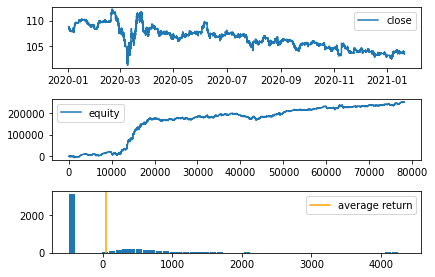

In [14]:
mybot.backtest(from_date=start, to_date=end, filename="hogebacktest.png", show=True)

total profit        25330.000
total trades          516.000
win rate               50.194
profit factor           1.187
maximum drawdown     9240.000
recovery factor         2.741
riskreward ratio        1.242
sharpe ratio            0.074
average return         45.716
stop loss             271.000
take profit             0.000
dtype: float64


total profit        25330.000
total trades          516.000
win rate               50.194
profit factor           1.187
maximum drawdown     9240.000
recovery factor         2.741
riskreward ratio        1.242
sharpe ratio            0.074
average return         45.716
stop loss             271.000
take profit             0.000
dtype: float64

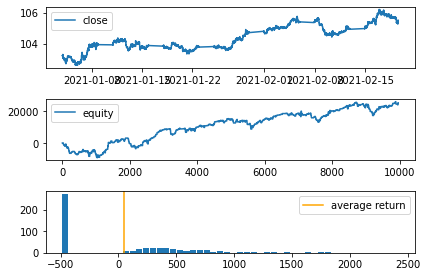

In [15]:
start_rev = "2021-1-1"
end_rev = "2021-2-19"
mybot.backtest(from_date=start_rev, to_date=end_rev, filename="hogebacktest.png", show=True)

In [16]:
#total profit        14490.000